# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


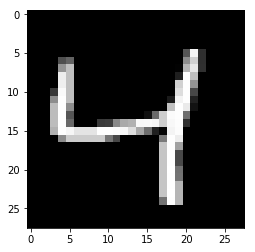

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1], name = 'input')
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1], name = 'targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, 3, 1, padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='valid')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, 3, 1, padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='valid')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, 3, 1, padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, 2, 2, padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, [7, 7])
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, 3, 1, padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, [14, 14])
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, 3, 1, padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, [28, 28])
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, 3, 1, padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(upsample3, 1, 3, 1, padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6961
Epoch: 1/20... Training loss: 0.6927
Epoch: 1/20... Training loss: 0.6900
Epoch: 1/20... Training loss: 0.6871
Epoch: 1/20... Training loss: 0.6841
Epoch: 1/20... Training loss: 0.6805
Epoch: 1/20... Training loss: 0.6765
Epoch: 1/20... Training loss: 0.6720
Epoch: 1/20... Training loss: 0.6656
Epoch: 1/20... Training loss: 0.6595
Epoch: 1/20... Training loss: 0.6527
Epoch: 1/20... Training loss: 0.6437
Epoch: 1/20... Training loss: 0.6331
Epoch: 1/20... Training loss: 0.6233
Epoch: 1/20... Training loss: 0.6103
Epoch: 1/20... Training loss: 0.5948
Epoch: 1/20... Training loss: 0.5829
Epoch: 1/20... Training loss: 0.5680
Epoch: 1/20... Training loss: 0.5571
Epoch: 1/20... Training loss: 0.5424
Epoch: 1/20... Training loss: 0.5305
Epoch: 1/20... Training loss: 0.5137
Epoch: 1/20... Training loss: 0.5199
Epoch: 1/20... Training loss: 0.5367
Epoch: 1/20... Training loss: 0.5221
Epoch: 1/20... Training loss: 0.5223
Epoch: 1/20... Training loss: 0.5205
E

Epoch: 1/20... Training loss: 0.1816
Epoch: 1/20... Training loss: 0.1744
Epoch: 1/20... Training loss: 0.1748
Epoch: 1/20... Training loss: 0.1777
Epoch: 1/20... Training loss: 0.1800
Epoch: 1/20... Training loss: 0.1716
Epoch: 1/20... Training loss: 0.1756
Epoch: 1/20... Training loss: 0.1780
Epoch: 1/20... Training loss: 0.1749
Epoch: 1/20... Training loss: 0.1782
Epoch: 1/20... Training loss: 0.1719
Epoch: 1/20... Training loss: 0.1794
Epoch: 1/20... Training loss: 0.1712
Epoch: 1/20... Training loss: 0.1691
Epoch: 1/20... Training loss: 0.1797
Epoch: 1/20... Training loss: 0.1774
Epoch: 1/20... Training loss: 0.1746
Epoch: 1/20... Training loss: 0.1720
Epoch: 1/20... Training loss: 0.1713
Epoch: 1/20... Training loss: 0.1782
Epoch: 1/20... Training loss: 0.1724
Epoch: 1/20... Training loss: 0.1683
Epoch: 1/20... Training loss: 0.1724
Epoch: 1/20... Training loss: 0.1696
Epoch: 1/20... Training loss: 0.1707
Epoch: 1/20... Training loss: 0.1716
Epoch: 1/20... Training loss: 0.1735
E

Epoch: 2/20... Training loss: 0.1432
Epoch: 2/20... Training loss: 0.1413
Epoch: 2/20... Training loss: 0.1428
Epoch: 2/20... Training loss: 0.1460
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1453
Epoch: 2/20... Training loss: 0.1430
Epoch: 2/20... Training loss: 0.1447
Epoch: 2/20... Training loss: 0.1445
Epoch: 2/20... Training loss: 0.1455
Epoch: 2/20... Training loss: 0.1493
Epoch: 2/20... Training loss: 0.1440
Epoch: 2/20... Training loss: 0.1483
Epoch: 2/20... Training loss: 0.1446
Epoch: 2/20... Training loss: 0.1455
Epoch: 2/20... Training loss: 0.1392
Epoch: 2/20... Training loss: 0.1456
Epoch: 2/20... Training loss: 0.1399
Epoch: 2/20... Training loss: 0.1455
Epoch: 2/20... Training loss: 0.1416
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1463
Epoch: 2/20... Training loss: 0.1400
Epoch: 2/20... Training loss: 0.1472
Epoch: 2/20... Training loss: 0.1450
Epoch: 2/20... Training loss: 0.1419
Epoch: 2/20... Training loss: 0.1440
E

Epoch: 3/20... Training loss: 0.1329
Epoch: 3/20... Training loss: 0.1306
Epoch: 3/20... Training loss: 0.1367
Epoch: 3/20... Training loss: 0.1389
Epoch: 3/20... Training loss: 0.1353
Epoch: 3/20... Training loss: 0.1388
Epoch: 3/20... Training loss: 0.1330
Epoch: 3/20... Training loss: 0.1359
Epoch: 3/20... Training loss: 0.1282
Epoch: 3/20... Training loss: 0.1313
Epoch: 3/20... Training loss: 0.1332
Epoch: 3/20... Training loss: 0.1315
Epoch: 3/20... Training loss: 0.1337
Epoch: 3/20... Training loss: 0.1378
Epoch: 3/20... Training loss: 0.1343
Epoch: 3/20... Training loss: 0.1295
Epoch: 3/20... Training loss: 0.1284
Epoch: 3/20... Training loss: 0.1266
Epoch: 3/20... Training loss: 0.1322
Epoch: 3/20... Training loss: 0.1396
Epoch: 3/20... Training loss: 0.1326
Epoch: 3/20... Training loss: 0.1306
Epoch: 3/20... Training loss: 0.1336
Epoch: 3/20... Training loss: 0.1310
Epoch: 3/20... Training loss: 0.1326
Epoch: 3/20... Training loss: 0.1322
Epoch: 3/20... Training loss: 0.1408
E

Epoch: 4/20... Training loss: 0.1302
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1271
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1222
Epoch: 4/20... Training loss: 0.1311
Epoch: 4/20... Training loss: 0.1264
Epoch: 4/20... Training loss: 0.1264
Epoch: 4/20... Training loss: 0.1360
Epoch: 4/20... Training loss: 0.1253
Epoch: 4/20... Training loss: 0.1303
Epoch: 4/20... Training loss: 0.1264
Epoch: 4/20... Training loss: 0.1280
Epoch: 4/20... Training loss: 0.1303
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1268
Epoch: 4/20... Training loss: 0.1283
Epoch: 4/20... Training loss: 0.1327
Epoch: 4/20... Training loss: 0.1216
Epoch: 4/20... Training loss: 0.1307
Epoch: 4/20... Training loss: 0.1287
Epoch: 4/20... Training loss: 0.1250
Epoch: 4/20... Training loss: 0.1270
Epoch: 4/20... Training loss: 0.1268
Epoch: 4/20... Training loss: 0.1299
Epoch: 4/20... Training loss: 0.1291
E

Epoch: 4/20... Training loss: 0.1237
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1252
Epoch: 4/20... Training loss: 0.1257
Epoch: 4/20... Training loss: 0.1237
Epoch: 4/20... Training loss: 0.1251
Epoch: 4/20... Training loss: 0.1263
Epoch: 4/20... Training loss: 0.1210
Epoch: 4/20... Training loss: 0.1228
Epoch: 4/20... Training loss: 0.1258
Epoch: 4/20... Training loss: 0.1199
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1246
Epoch: 4/20... Training loss: 0.1243
Epoch: 5/20... Training loss: 0.1237
Epoch: 5/20... Training loss: 0.1239
Epoch: 5/20... Training loss: 0.1272
Epoch: 5/20... Training loss: 0.1212
Epoch: 5/20... Training loss: 0.1260
Epoch: 5/20... Training loss: 0.1223
Epoch: 5/20... Training loss: 0.1267
Epoch: 5/20... Training loss: 0.1249
Epoch: 5/20... Training loss: 0.1310
Epoch: 5/20... Training loss: 0.1198
Epoch: 5/20... Training loss: 0.1235
Epoch: 5/20... Training loss: 0.1244
E

Epoch: 5/20... Training loss: 0.1201
Epoch: 5/20... Training loss: 0.1170
Epoch: 5/20... Training loss: 0.1173
Epoch: 5/20... Training loss: 0.1200
Epoch: 5/20... Training loss: 0.1235
Epoch: 5/20... Training loss: 0.1198
Epoch: 5/20... Training loss: 0.1134
Epoch: 5/20... Training loss: 0.1210
Epoch: 5/20... Training loss: 0.1222
Epoch: 5/20... Training loss: 0.1180
Epoch: 5/20... Training loss: 0.1162
Epoch: 5/20... Training loss: 0.1247
Epoch: 5/20... Training loss: 0.1217
Epoch: 5/20... Training loss: 0.1191
Epoch: 5/20... Training loss: 0.1215
Epoch: 5/20... Training loss: 0.1230
Epoch: 5/20... Training loss: 0.1202
Epoch: 5/20... Training loss: 0.1159
Epoch: 5/20... Training loss: 0.1223
Epoch: 5/20... Training loss: 0.1186
Epoch: 5/20... Training loss: 0.1194
Epoch: 5/20... Training loss: 0.1167
Epoch: 5/20... Training loss: 0.1216
Epoch: 5/20... Training loss: 0.1189
Epoch: 5/20... Training loss: 0.1191
Epoch: 5/20... Training loss: 0.1204
Epoch: 5/20... Training loss: 0.1155
E

Epoch: 6/20... Training loss: 0.1191
Epoch: 6/20... Training loss: 0.1163
Epoch: 6/20... Training loss: 0.1151
Epoch: 6/20... Training loss: 0.1168
Epoch: 6/20... Training loss: 0.1190
Epoch: 6/20... Training loss: 0.1176
Epoch: 6/20... Training loss: 0.1198
Epoch: 6/20... Training loss: 0.1205
Epoch: 6/20... Training loss: 0.1165
Epoch: 6/20... Training loss: 0.1146
Epoch: 6/20... Training loss: 0.1141
Epoch: 6/20... Training loss: 0.1157
Epoch: 6/20... Training loss: 0.1207
Epoch: 6/20... Training loss: 0.1209
Epoch: 6/20... Training loss: 0.1146
Epoch: 6/20... Training loss: 0.1166
Epoch: 6/20... Training loss: 0.1142
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1151
Epoch: 6/20... Training loss: 0.1163
Epoch: 6/20... Training loss: 0.1185
Epoch: 6/20... Training loss: 0.1156
Epoch: 6/20... Training loss: 0.1163
Epoch: 6/20... Training loss: 0.1189
Epoch: 6/20... Training loss: 0.1228
Epoch: 6/20... Training loss: 0.1160
Epoch: 6/20... Training loss: 0.1203
E

Epoch: 7/20... Training loss: 0.1115
Epoch: 7/20... Training loss: 0.1176
Epoch: 7/20... Training loss: 0.1120
Epoch: 7/20... Training loss: 0.1137
Epoch: 7/20... Training loss: 0.1135
Epoch: 7/20... Training loss: 0.1125
Epoch: 7/20... Training loss: 0.1133
Epoch: 7/20... Training loss: 0.1177
Epoch: 7/20... Training loss: 0.1163
Epoch: 7/20... Training loss: 0.1088
Epoch: 7/20... Training loss: 0.1166
Epoch: 7/20... Training loss: 0.1165
Epoch: 7/20... Training loss: 0.1165
Epoch: 7/20... Training loss: 0.1153
Epoch: 7/20... Training loss: 0.1134
Epoch: 7/20... Training loss: 0.1123
Epoch: 7/20... Training loss: 0.1167
Epoch: 7/20... Training loss: 0.1124
Epoch: 7/20... Training loss: 0.1167
Epoch: 7/20... Training loss: 0.1136
Epoch: 7/20... Training loss: 0.1162
Epoch: 7/20... Training loss: 0.1167
Epoch: 7/20... Training loss: 0.1124
Epoch: 7/20... Training loss: 0.1159
Epoch: 7/20... Training loss: 0.1134
Epoch: 7/20... Training loss: 0.1167
Epoch: 7/20... Training loss: 0.1147
E

Epoch: 8/20... Training loss: 0.1191
Epoch: 8/20... Training loss: 0.1125
Epoch: 8/20... Training loss: 0.1129
Epoch: 8/20... Training loss: 0.1163
Epoch: 8/20... Training loss: 0.1161
Epoch: 8/20... Training loss: 0.1159
Epoch: 8/20... Training loss: 0.1107
Epoch: 8/20... Training loss: 0.1163
Epoch: 8/20... Training loss: 0.1150
Epoch: 8/20... Training loss: 0.1141
Epoch: 8/20... Training loss: 0.1095
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1132
Epoch: 8/20... Training loss: 0.1124
Epoch: 8/20... Training loss: 0.1157
Epoch: 8/20... Training loss: 0.1113
Epoch: 8/20... Training loss: 0.1114
Epoch: 8/20... Training loss: 0.1118
Epoch: 8/20... Training loss: 0.1113
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1153
Epoch: 8/20... Training loss: 0.1138
Epoch: 8/20... Training loss: 0.1123
Epoch: 8/20... Training loss: 0.1110
Epoch: 8/20... Training loss: 0.1124
Epoch: 8/20... Training loss: 0.1138
Epoch: 8/20... Training loss: 0.1186
E

Epoch: 8/20... Training loss: 0.1123
Epoch: 8/20... Training loss: 0.1137
Epoch: 8/20... Training loss: 0.1097
Epoch: 8/20... Training loss: 0.1134
Epoch: 8/20... Training loss: 0.1152
Epoch: 8/20... Training loss: 0.1122
Epoch: 8/20... Training loss: 0.1100
Epoch: 8/20... Training loss: 0.1150
Epoch: 8/20... Training loss: 0.1108
Epoch: 8/20... Training loss: 0.1126
Epoch: 8/20... Training loss: 0.1165
Epoch: 8/20... Training loss: 0.1138
Epoch: 8/20... Training loss: 0.1107
Epoch: 9/20... Training loss: 0.1107
Epoch: 9/20... Training loss: 0.1138
Epoch: 9/20... Training loss: 0.1119
Epoch: 9/20... Training loss: 0.1115
Epoch: 9/20... Training loss: 0.1156
Epoch: 9/20... Training loss: 0.1128
Epoch: 9/20... Training loss: 0.1099
Epoch: 9/20... Training loss: 0.1149
Epoch: 9/20... Training loss: 0.1113
Epoch: 9/20... Training loss: 0.1123
Epoch: 9/20... Training loss: 0.1127
Epoch: 9/20... Training loss: 0.1122
Epoch: 9/20... Training loss: 0.1134
Epoch: 9/20... Training loss: 0.1097
E

Epoch: 9/20... Training loss: 0.1114
Epoch: 9/20... Training loss: 0.1129
Epoch: 9/20... Training loss: 0.1119
Epoch: 9/20... Training loss: 0.1113
Epoch: 9/20... Training loss: 0.1072
Epoch: 9/20... Training loss: 0.1051
Epoch: 9/20... Training loss: 0.1130
Epoch: 9/20... Training loss: 0.1131
Epoch: 9/20... Training loss: 0.1122
Epoch: 9/20... Training loss: 0.1111
Epoch: 9/20... Training loss: 0.1055
Epoch: 9/20... Training loss: 0.1109
Epoch: 9/20... Training loss: 0.1092
Epoch: 9/20... Training loss: 0.1102
Epoch: 9/20... Training loss: 0.1113
Epoch: 9/20... Training loss: 0.1125
Epoch: 9/20... Training loss: 0.1131
Epoch: 9/20... Training loss: 0.1129
Epoch: 9/20... Training loss: 0.1096
Epoch: 9/20... Training loss: 0.1100
Epoch: 9/20... Training loss: 0.1133
Epoch: 9/20... Training loss: 0.1078
Epoch: 9/20... Training loss: 0.1104
Epoch: 9/20... Training loss: 0.1069
Epoch: 9/20... Training loss: 0.1115
Epoch: 9/20... Training loss: 0.1112
Epoch: 9/20... Training loss: 0.1103
E

Epoch: 10/20... Training loss: 0.1131
Epoch: 10/20... Training loss: 0.1110
Epoch: 10/20... Training loss: 0.1072
Epoch: 10/20... Training loss: 0.1137
Epoch: 10/20... Training loss: 0.1114
Epoch: 10/20... Training loss: 0.1084
Epoch: 10/20... Training loss: 0.1117
Epoch: 10/20... Training loss: 0.1111
Epoch: 10/20... Training loss: 0.1085
Epoch: 10/20... Training loss: 0.1090
Epoch: 10/20... Training loss: 0.1094
Epoch: 10/20... Training loss: 0.1096
Epoch: 10/20... Training loss: 0.1109
Epoch: 10/20... Training loss: 0.1140
Epoch: 10/20... Training loss: 0.1103
Epoch: 10/20... Training loss: 0.1121
Epoch: 10/20... Training loss: 0.1084
Epoch: 10/20... Training loss: 0.1086
Epoch: 10/20... Training loss: 0.1117
Epoch: 10/20... Training loss: 0.1119
Epoch: 10/20... Training loss: 0.1089
Epoch: 10/20... Training loss: 0.1129
Epoch: 10/20... Training loss: 0.1082
Epoch: 10/20... Training loss: 0.1176
Epoch: 10/20... Training loss: 0.1123
Epoch: 10/20... Training loss: 0.1084
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1084
Epoch: 11/20... Training loss: 0.1106
Epoch: 11/20... Training loss: 0.1089
Epoch: 11/20... Training loss: 0.1109
Epoch: 11/20... Training loss: 0.1114
Epoch: 11/20... Training loss: 0.1088
Epoch: 11/20... Training loss: 0.1079
Epoch: 11/20... Training loss: 0.1119
Epoch: 11/20... Training loss: 0.1078
Epoch: 11/20... Training loss: 0.1056
Epoch: 11/20... Training loss: 0.1072
Epoch: 11/20... Training loss: 0.1085
Epoch: 11/20... Training loss: 0.1113
Epoch: 11/20... Training loss: 0.1094
Epoch: 11/20... Training loss: 0.1114
Epoch: 11/20... Training loss: 0.1103
Epoch: 11/20... Training loss: 0.1050
Epoch: 11/20... Training loss: 0.1097
Epoch: 11/20... Training loss: 0.1129
Epoch: 11/20... Training loss: 0.1075
Epoch: 11/20... Training loss: 0.1095
Epoch: 11/20... Training loss: 0.1060
Epoch: 11/20... Training loss: 0.1131
Epoch: 11/20... Training loss: 0.1079
Epoch: 11/20... Training loss: 0.1146
Epoch: 11/20... Training loss: 0.1113
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1081
Epoch: 12/20... Training loss: 0.1044
Epoch: 12/20... Training loss: 0.1082
Epoch: 12/20... Training loss: 0.1055
Epoch: 12/20... Training loss: 0.1084
Epoch: 12/20... Training loss: 0.1105
Epoch: 12/20... Training loss: 0.1104
Epoch: 12/20... Training loss: 0.1104
Epoch: 12/20... Training loss: 0.1059
Epoch: 12/20... Training loss: 0.1063
Epoch: 12/20... Training loss: 0.1109
Epoch: 12/20... Training loss: 0.1093
Epoch: 12/20... Training loss: 0.1079
Epoch: 12/20... Training loss: 0.1064
Epoch: 12/20... Training loss: 0.1066
Epoch: 12/20... Training loss: 0.1085
Epoch: 12/20... Training loss: 0.1044
Epoch: 12/20... Training loss: 0.1090
Epoch: 12/20... Training loss: 0.1079
Epoch: 12/20... Training loss: 0.1091
Epoch: 12/20... Training loss: 0.1071
Epoch: 12/20... Training loss: 0.1084
Epoch: 12/20... Training loss: 0.1130
Epoch: 12/20... Training loss: 0.1083
Epoch: 12/20... Training loss: 0.1116
Epoch: 12/20... Training loss: 0.1088
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1078
Epoch: 12/20... Training loss: 0.1073
Epoch: 12/20... Training loss: 0.1094
Epoch: 12/20... Training loss: 0.1113
Epoch: 12/20... Training loss: 0.1077
Epoch: 12/20... Training loss: 0.1080
Epoch: 12/20... Training loss: 0.1095
Epoch: 12/20... Training loss: 0.1060
Epoch: 12/20... Training loss: 0.1112
Epoch: 12/20... Training loss: 0.1110
Epoch: 12/20... Training loss: 0.1043
Epoch: 12/20... Training loss: 0.1090
Epoch: 12/20... Training loss: 0.1067
Epoch: 12/20... Training loss: 0.1060
Epoch: 12/20... Training loss: 0.1091
Epoch: 12/20... Training loss: 0.1086
Epoch: 12/20... Training loss: 0.1100
Epoch: 12/20... Training loss: 0.1106
Epoch: 12/20... Training loss: 0.1104
Epoch: 12/20... Training loss: 0.1062
Epoch: 12/20... Training loss: 0.1081
Epoch: 12/20... Training loss: 0.1080
Epoch: 12/20... Training loss: 0.1091
Epoch: 12/20... Training loss: 0.1075
Epoch: 12/20... Training loss: 0.1032
Epoch: 12/20... Training loss: 0.1021
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1047
Epoch: 13/20... Training loss: 0.1068
Epoch: 13/20... Training loss: 0.1034
Epoch: 13/20... Training loss: 0.1084
Epoch: 13/20... Training loss: 0.1036
Epoch: 13/20... Training loss: 0.1063
Epoch: 13/20... Training loss: 0.1103
Epoch: 13/20... Training loss: 0.1089
Epoch: 13/20... Training loss: 0.1091
Epoch: 13/20... Training loss: 0.1102
Epoch: 13/20... Training loss: 0.1085
Epoch: 13/20... Training loss: 0.1088
Epoch: 13/20... Training loss: 0.1021
Epoch: 13/20... Training loss: 0.1086
Epoch: 13/20... Training loss: 0.1078
Epoch: 13/20... Training loss: 0.1045
Epoch: 13/20... Training loss: 0.1100
Epoch: 13/20... Training loss: 0.1015
Epoch: 13/20... Training loss: 0.1067
Epoch: 13/20... Training loss: 0.1077
Epoch: 13/20... Training loss: 0.1073
Epoch: 13/20... Training loss: 0.1065
Epoch: 13/20... Training loss: 0.1075
Epoch: 13/20... Training loss: 0.1046
Epoch: 13/20... Training loss: 0.1080
Epoch: 13/20... Training loss: 0.1065
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1059
Epoch: 14/20... Training loss: 0.1112
Epoch: 14/20... Training loss: 0.1079
Epoch: 14/20... Training loss: 0.1092
Epoch: 14/20... Training loss: 0.1061
Epoch: 14/20... Training loss: 0.1083
Epoch: 14/20... Training loss: 0.1062
Epoch: 14/20... Training loss: 0.1066
Epoch: 14/20... Training loss: 0.1023
Epoch: 14/20... Training loss: 0.1049
Epoch: 14/20... Training loss: 0.1038
Epoch: 14/20... Training loss: 0.1012
Epoch: 14/20... Training loss: 0.1035
Epoch: 14/20... Training loss: 0.1073
Epoch: 14/20... Training loss: 0.1059
Epoch: 14/20... Training loss: 0.1083
Epoch: 14/20... Training loss: 0.1056
Epoch: 14/20... Training loss: 0.1062
Epoch: 14/20... Training loss: 0.1061
Epoch: 14/20... Training loss: 0.1062
Epoch: 14/20... Training loss: 0.1064
Epoch: 14/20... Training loss: 0.1057
Epoch: 14/20... Training loss: 0.1089
Epoch: 14/20... Training loss: 0.1068
Epoch: 14/20... Training loss: 0.1084
Epoch: 14/20... Training loss: 0.1034
Epoch: 14/20

Epoch: 15/20... Training loss: 0.1035
Epoch: 15/20... Training loss: 0.1045
Epoch: 15/20... Training loss: 0.1038
Epoch: 15/20... Training loss: 0.1054
Epoch: 15/20... Training loss: 0.1070
Epoch: 15/20... Training loss: 0.1042
Epoch: 15/20... Training loss: 0.1069
Epoch: 15/20... Training loss: 0.1049
Epoch: 15/20... Training loss: 0.1040
Epoch: 15/20... Training loss: 0.1040
Epoch: 15/20... Training loss: 0.1035
Epoch: 15/20... Training loss: 0.1053
Epoch: 15/20... Training loss: 0.1060
Epoch: 15/20... Training loss: 0.1062
Epoch: 15/20... Training loss: 0.1053
Epoch: 15/20... Training loss: 0.1073
Epoch: 15/20... Training loss: 0.1111
Epoch: 15/20... Training loss: 0.1078
Epoch: 15/20... Training loss: 0.1047
Epoch: 15/20... Training loss: 0.1037
Epoch: 15/20... Training loss: 0.1068
Epoch: 15/20... Training loss: 0.1088
Epoch: 15/20... Training loss: 0.1088
Epoch: 15/20... Training loss: 0.1051
Epoch: 15/20... Training loss: 0.1080
Epoch: 15/20... Training loss: 0.1091
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1030
Epoch: 15/20... Training loss: 0.1050
Epoch: 15/20... Training loss: 0.1068
Epoch: 15/20... Training loss: 0.1079
Epoch: 15/20... Training loss: 0.1043
Epoch: 15/20... Training loss: 0.1072
Epoch: 15/20... Training loss: 0.1071
Epoch: 15/20... Training loss: 0.1100
Epoch: 15/20... Training loss: 0.1023
Epoch: 15/20... Training loss: 0.1087
Epoch: 15/20... Training loss: 0.1042
Epoch: 15/20... Training loss: 0.1087
Epoch: 15/20... Training loss: 0.1016
Epoch: 15/20... Training loss: 0.1069
Epoch: 15/20... Training loss: 0.1063
Epoch: 15/20... Training loss: 0.1061
Epoch: 15/20... Training loss: 0.1046
Epoch: 15/20... Training loss: 0.1055
Epoch: 15/20... Training loss: 0.1064
Epoch: 15/20... Training loss: 0.1055
Epoch: 15/20... Training loss: 0.1049
Epoch: 15/20... Training loss: 0.1024
Epoch: 15/20... Training loss: 0.1051
Epoch: 15/20... Training loss: 0.1115
Epoch: 15/20... Training loss: 0.1035
Epoch: 15/20... Training loss: 0.1037
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1047
Epoch: 16/20... Training loss: 0.1026
Epoch: 16/20... Training loss: 0.1083
Epoch: 16/20... Training loss: 0.1026
Epoch: 16/20... Training loss: 0.1092
Epoch: 16/20... Training loss: 0.1062
Epoch: 16/20... Training loss: 0.1073
Epoch: 16/20... Training loss: 0.1058
Epoch: 16/20... Training loss: 0.1084
Epoch: 16/20... Training loss: 0.1059
Epoch: 16/20... Training loss: 0.1040
Epoch: 16/20... Training loss: 0.1083
Epoch: 16/20... Training loss: 0.1020
Epoch: 16/20... Training loss: 0.1060
Epoch: 16/20... Training loss: 0.1023
Epoch: 16/20... Training loss: 0.1039
Epoch: 16/20... Training loss: 0.1064
Epoch: 16/20... Training loss: 0.1026
Epoch: 16/20... Training loss: 0.1092
Epoch: 16/20... Training loss: 0.1054
Epoch: 16/20... Training loss: 0.1086
Epoch: 16/20... Training loss: 0.1080
Epoch: 16/20... Training loss: 0.1117
Epoch: 16/20... Training loss: 0.1022
Epoch: 16/20... Training loss: 0.1069
Epoch: 16/20... Training loss: 0.1033
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1029
Epoch: 17/20... Training loss: 0.1037
Epoch: 17/20... Training loss: 0.1052
Epoch: 17/20... Training loss: 0.1040
Epoch: 17/20... Training loss: 0.1097
Epoch: 17/20... Training loss: 0.1034
Epoch: 17/20... Training loss: 0.1058
Epoch: 17/20... Training loss: 0.1053
Epoch: 17/20... Training loss: 0.1041
Epoch: 17/20... Training loss: 0.1039
Epoch: 17/20... Training loss: 0.1019
Epoch: 17/20... Training loss: 0.1061
Epoch: 17/20... Training loss: 0.1066
Epoch: 17/20... Training loss: 0.1038
Epoch: 17/20... Training loss: 0.1049
Epoch: 17/20... Training loss: 0.1080
Epoch: 17/20... Training loss: 0.1081
Epoch: 17/20... Training loss: 0.1058
Epoch: 17/20... Training loss: 0.1065
Epoch: 17/20... Training loss: 0.1115
Epoch: 17/20... Training loss: 0.1081
Epoch: 17/20... Training loss: 0.1065
Epoch: 17/20... Training loss: 0.1044
Epoch: 17/20... Training loss: 0.0997
Epoch: 17/20... Training loss: 0.1026
Epoch: 17/20... Training loss: 0.1084
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1040
Epoch: 18/20... Training loss: 0.1050
Epoch: 18/20... Training loss: 0.1089
Epoch: 18/20... Training loss: 0.1075
Epoch: 18/20... Training loss: 0.1043
Epoch: 18/20... Training loss: 0.0975
Epoch: 18/20... Training loss: 0.1029
Epoch: 18/20... Training loss: 0.1039
Epoch: 18/20... Training loss: 0.1000
Epoch: 18/20... Training loss: 0.1065
Epoch: 18/20... Training loss: 0.1050
Epoch: 18/20... Training loss: 0.1029
Epoch: 18/20... Training loss: 0.1069
Epoch: 18/20... Training loss: 0.1081
Epoch: 18/20... Training loss: 0.1078
Epoch: 18/20... Training loss: 0.1047
Epoch: 18/20... Training loss: 0.1042
Epoch: 18/20... Training loss: 0.1036
Epoch: 18/20... Training loss: 0.1046
Epoch: 18/20... Training loss: 0.1061
Epoch: 18/20... Training loss: 0.1058
Epoch: 18/20... Training loss: 0.1029
Epoch: 18/20... Training loss: 0.1073
Epoch: 18/20... Training loss: 0.1055
Epoch: 18/20... Training loss: 0.1069
Epoch: 18/20... Training loss: 0.1055
Epoch: 18/20

Epoch: 18/20... Training loss: 0.1055
Epoch: 18/20... Training loss: 0.1053
Epoch: 18/20... Training loss: 0.1036
Epoch: 18/20... Training loss: 0.1028
Epoch: 18/20... Training loss: 0.1013
Epoch: 19/20... Training loss: 0.1060
Epoch: 19/20... Training loss: 0.1009
Epoch: 19/20... Training loss: 0.1002
Epoch: 19/20... Training loss: 0.1042
Epoch: 19/20... Training loss: 0.1008
Epoch: 19/20... Training loss: 0.1044
Epoch: 19/20... Training loss: 0.1047
Epoch: 19/20... Training loss: 0.1067
Epoch: 19/20... Training loss: 0.1042
Epoch: 19/20... Training loss: 0.1039
Epoch: 19/20... Training loss: 0.1060
Epoch: 19/20... Training loss: 0.1036
Epoch: 19/20... Training loss: 0.1055
Epoch: 19/20... Training loss: 0.1054
Epoch: 19/20... Training loss: 0.1090
Epoch: 19/20... Training loss: 0.1020
Epoch: 19/20... Training loss: 0.1049
Epoch: 19/20... Training loss: 0.1012
Epoch: 19/20... Training loss: 0.1019
Epoch: 19/20... Training loss: 0.1086
Epoch: 19/20... Training loss: 0.1016
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1031
Epoch: 19/20... Training loss: 0.1012
Epoch: 19/20... Training loss: 0.1051
Epoch: 19/20... Training loss: 0.0988
Epoch: 19/20... Training loss: 0.1043
Epoch: 19/20... Training loss: 0.1083
Epoch: 19/20... Training loss: 0.1051
Epoch: 19/20... Training loss: 0.1061
Epoch: 19/20... Training loss: 0.1063
Epoch: 19/20... Training loss: 0.1056
Epoch: 19/20... Training loss: 0.1052
Epoch: 19/20... Training loss: 0.1068
Epoch: 19/20... Training loss: 0.1035
Epoch: 19/20... Training loss: 0.1020
Epoch: 19/20... Training loss: 0.1046
Epoch: 19/20... Training loss: 0.1015
Epoch: 19/20... Training loss: 0.0993
Epoch: 19/20... Training loss: 0.0970
Epoch: 19/20... Training loss: 0.1005
Epoch: 19/20... Training loss: 0.1056
Epoch: 19/20... Training loss: 0.1033
Epoch: 19/20... Training loss: 0.1003
Epoch: 19/20... Training loss: 0.1083
Epoch: 19/20... Training loss: 0.1028
Epoch: 19/20... Training loss: 0.1002
Epoch: 19/20... Training loss: 0.1058
Epoch: 19/20

Epoch: 20/20... Training loss: 0.1042
Epoch: 20/20... Training loss: 0.1055
Epoch: 20/20... Training loss: 0.1040
Epoch: 20/20... Training loss: 0.0977
Epoch: 20/20... Training loss: 0.1045
Epoch: 20/20... Training loss: 0.1085
Epoch: 20/20... Training loss: 0.1048
Epoch: 20/20... Training loss: 0.1017
Epoch: 20/20... Training loss: 0.1043
Epoch: 20/20... Training loss: 0.1040
Epoch: 20/20... Training loss: 0.1053
Epoch: 20/20... Training loss: 0.1048
Epoch: 20/20... Training loss: 0.0994
Epoch: 20/20... Training loss: 0.1029
Epoch: 20/20... Training loss: 0.1001
Epoch: 20/20... Training loss: 0.1015
Epoch: 20/20... Training loss: 0.1074
Epoch: 20/20... Training loss: 0.1021
Epoch: 20/20... Training loss: 0.1028
Epoch: 20/20... Training loss: 0.1025
Epoch: 20/20... Training loss: 0.1043
Epoch: 20/20... Training loss: 0.1051
Epoch: 20/20... Training loss: 0.1054
Epoch: 20/20... Training loss: 0.1062
Epoch: 20/20... Training loss: 0.1049
Epoch: 20/20... Training loss: 0.1043
Epoch: 20/20

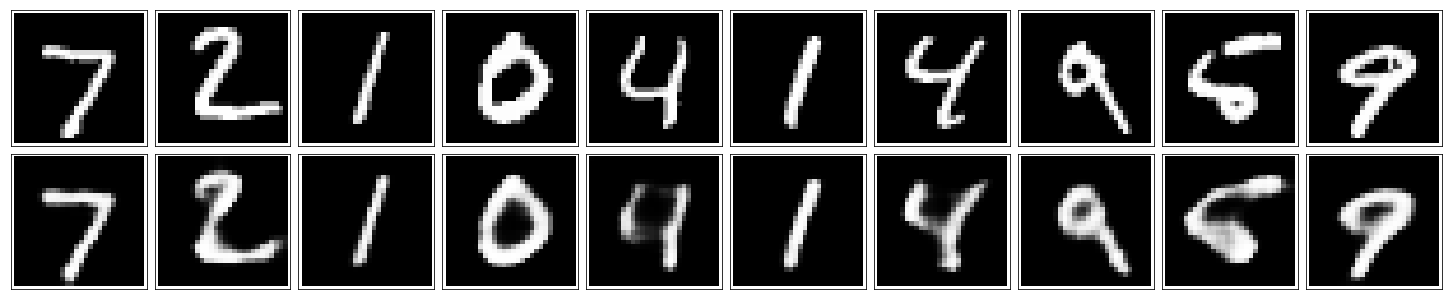

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [11]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [12]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 =  tf.layers.conv2d(inputs_, 32, 3, 1, padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='valid')
# Now 14x14x32
conv2 =  tf.layers.conv2d(maxpool1, 32, 3, 1, padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='valid')
# Now 7x7x32
conv3 =  tf.layers.conv2d(maxpool2, 16, 3, 1, padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv2, 2, 2, padding='valid')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, [7, 7])
# Now 7x7x16
conv4 =  tf.layers.conv2d(upsample1, 16, 3, 1, padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, [14, 14])
# Now 14x14x16
conv5 =  tf.layers.conv2d(upsample2, 32, 3, 1, padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, [28, 28])
# Now 28x28x32
conv6 =  tf.layers.conv2d(upsample3, 32, 3, 1, padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits =  tf.layers.conv2d(conv6, 1, 3, 1, padding='same')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [13]:
sess = tf.Session()

In [14]:
epochs = 20
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6924
Epoch: 1/20... Training loss: 0.6766
Epoch: 1/20... Training loss: 0.6529
Epoch: 1/20... Training loss: 0.6209
Epoch: 1/20... Training loss: 0.5818
Epoch: 1/20... Training loss: 0.5431
Epoch: 1/20... Training loss: 0.5082
Epoch: 1/20... Training loss: 0.5029
Epoch: 1/20... Training loss: 0.5204
Epoch: 1/20... Training loss: 0.5159
Epoch: 1/20... Training loss: 0.5083
Epoch: 1/20... Training loss: 0.4890
Epoch: 1/20... Training loss: 0.4852
Epoch: 1/20... Training loss: 0.4854
Epoch: 1/20... Training loss: 0.4797
Epoch: 1/20... Training loss: 0.4637
Epoch: 1/20... Training loss: 0.4756
Epoch: 1/20... Training loss: 0.4666
Epoch: 1/20... Training loss: 0.4579
Epoch: 1/20... Training loss: 0.4503
Epoch: 1/20... Training loss: 0.4347
Epoch: 1/20... Training loss: 0.4353
Epoch: 1/20... Training loss: 0.4394
Epoch: 1/20... Training loss: 0.4262
Epoch: 1/20... Training loss: 0.4143
Epoch: 1/20... Training loss: 0.4052
Epoch: 1/20... Training loss: 0.4040
E

Epoch: 1/20... Training loss: 0.1336
Epoch: 1/20... Training loss: 0.1294
Epoch: 1/20... Training loss: 0.1307
Epoch: 1/20... Training loss: 0.1280
Epoch: 1/20... Training loss: 0.1336
Epoch: 1/20... Training loss: 0.1358
Epoch: 1/20... Training loss: 0.1284
Epoch: 1/20... Training loss: 0.1292
Epoch: 1/20... Training loss: 0.1278
Epoch: 1/20... Training loss: 0.1323
Epoch: 1/20... Training loss: 0.1275
Epoch: 1/20... Training loss: 0.1281
Epoch: 1/20... Training loss: 0.1292
Epoch: 1/20... Training loss: 0.1262
Epoch: 1/20... Training loss: 0.1315
Epoch: 1/20... Training loss: 0.1336
Epoch: 1/20... Training loss: 0.1274
Epoch: 1/20... Training loss: 0.1309
Epoch: 1/20... Training loss: 0.1302
Epoch: 1/20... Training loss: 0.1298
Epoch: 1/20... Training loss: 0.1302
Epoch: 1/20... Training loss: 0.1266
Epoch: 1/20... Training loss: 0.1275
Epoch: 1/20... Training loss: 0.1272
Epoch: 1/20... Training loss: 0.1263
Epoch: 1/20... Training loss: 0.1280
Epoch: 1/20... Training loss: 0.1303
E

Epoch: 2/20... Training loss: 0.1206
Epoch: 2/20... Training loss: 0.1193
Epoch: 2/20... Training loss: 0.1204
Epoch: 2/20... Training loss: 0.1176
Epoch: 2/20... Training loss: 0.1206
Epoch: 2/20... Training loss: 0.1214
Epoch: 2/20... Training loss: 0.1184
Epoch: 2/20... Training loss: 0.1180
Epoch: 2/20... Training loss: 0.1187
Epoch: 2/20... Training loss: 0.1167
Epoch: 2/20... Training loss: 0.1173
Epoch: 2/20... Training loss: 0.1172
Epoch: 2/20... Training loss: 0.1126
Epoch: 2/20... Training loss: 0.1177
Epoch: 2/20... Training loss: 0.1169
Epoch: 2/20... Training loss: 0.1199
Epoch: 2/20... Training loss: 0.1135
Epoch: 2/20... Training loss: 0.1151
Epoch: 2/20... Training loss: 0.1178
Epoch: 2/20... Training loss: 0.1191
Epoch: 2/20... Training loss: 0.1171
Epoch: 2/20... Training loss: 0.1163
Epoch: 2/20... Training loss: 0.1168
Epoch: 2/20... Training loss: 0.1153
Epoch: 2/20... Training loss: 0.1185
Epoch: 2/20... Training loss: 0.1166
Epoch: 2/20... Training loss: 0.1171
E

Epoch: 3/20... Training loss: 0.1103
Epoch: 3/20... Training loss: 0.1134
Epoch: 3/20... Training loss: 0.1128
Epoch: 3/20... Training loss: 0.1133
Epoch: 3/20... Training loss: 0.1098
Epoch: 3/20... Training loss: 0.1115
Epoch: 3/20... Training loss: 0.1097
Epoch: 3/20... Training loss: 0.1088
Epoch: 3/20... Training loss: 0.1125
Epoch: 3/20... Training loss: 0.1104
Epoch: 3/20... Training loss: 0.1079
Epoch: 3/20... Training loss: 0.1080
Epoch: 3/20... Training loss: 0.1093
Epoch: 3/20... Training loss: 0.1099
Epoch: 3/20... Training loss: 0.1090
Epoch: 3/20... Training loss: 0.1117
Epoch: 3/20... Training loss: 0.1107
Epoch: 3/20... Training loss: 0.1070
Epoch: 3/20... Training loss: 0.1081
Epoch: 3/20... Training loss: 0.1157
Epoch: 3/20... Training loss: 0.1168
Epoch: 3/20... Training loss: 0.1133
Epoch: 3/20... Training loss: 0.1124
Epoch: 3/20... Training loss: 0.1104
Epoch: 3/20... Training loss: 0.1067
Epoch: 3/20... Training loss: 0.1139
Epoch: 3/20... Training loss: 0.1130
E

Epoch: 4/20... Training loss: 0.1076
Epoch: 4/20... Training loss: 0.1042
Epoch: 4/20... Training loss: 0.1081
Epoch: 4/20... Training loss: 0.1085
Epoch: 4/20... Training loss: 0.1090
Epoch: 4/20... Training loss: 0.1112
Epoch: 4/20... Training loss: 0.1082
Epoch: 4/20... Training loss: 0.1074
Epoch: 4/20... Training loss: 0.1073
Epoch: 4/20... Training loss: 0.1094
Epoch: 4/20... Training loss: 0.1061
Epoch: 4/20... Training loss: 0.1069
Epoch: 4/20... Training loss: 0.1073
Epoch: 4/20... Training loss: 0.1095
Epoch: 4/20... Training loss: 0.1092
Epoch: 4/20... Training loss: 0.1064
Epoch: 4/20... Training loss: 0.1109
Epoch: 4/20... Training loss: 0.1081
Epoch: 4/20... Training loss: 0.1059
Epoch: 4/20... Training loss: 0.1073
Epoch: 4/20... Training loss: 0.1072
Epoch: 4/20... Training loss: 0.1072
Epoch: 4/20... Training loss: 0.1069
Epoch: 4/20... Training loss: 0.1080
Epoch: 4/20... Training loss: 0.1063
Epoch: 4/20... Training loss: 0.1059
Epoch: 4/20... Training loss: 0.1077
E

Epoch: 4/20... Training loss: 0.1036
Epoch: 4/20... Training loss: 0.1055
Epoch: 4/20... Training loss: 0.1045
Epoch: 4/20... Training loss: 0.1051
Epoch: 4/20... Training loss: 0.1062
Epoch: 4/20... Training loss: 0.1024
Epoch: 4/20... Training loss: 0.1069
Epoch: 4/20... Training loss: 0.1063
Epoch: 4/20... Training loss: 0.1098
Epoch: 4/20... Training loss: 0.1067
Epoch: 4/20... Training loss: 0.1012
Epoch: 4/20... Training loss: 0.1064
Epoch: 4/20... Training loss: 0.1061
Epoch: 4/20... Training loss: 0.1083
Epoch: 4/20... Training loss: 0.1062
Epoch: 4/20... Training loss: 0.1044
Epoch: 4/20... Training loss: 0.1053
Epoch: 4/20... Training loss: 0.1045
Epoch: 4/20... Training loss: 0.1117
Epoch: 4/20... Training loss: 0.1049
Epoch: 4/20... Training loss: 0.1035
Epoch: 4/20... Training loss: 0.1061
Epoch: 4/20... Training loss: 0.1083
Epoch: 4/20... Training loss: 0.1059
Epoch: 4/20... Training loss: 0.1050
Epoch: 4/20... Training loss: 0.1064
Epoch: 4/20... Training loss: 0.1027
E

Epoch: 5/20... Training loss: 0.1036
Epoch: 5/20... Training loss: 0.1059
Epoch: 5/20... Training loss: 0.1046
Epoch: 5/20... Training loss: 0.1071
Epoch: 5/20... Training loss: 0.1055
Epoch: 5/20... Training loss: 0.1048
Epoch: 5/20... Training loss: 0.1053
Epoch: 5/20... Training loss: 0.1012
Epoch: 5/20... Training loss: 0.1033
Epoch: 5/20... Training loss: 0.1056
Epoch: 5/20... Training loss: 0.1050
Epoch: 5/20... Training loss: 0.1048
Epoch: 5/20... Training loss: 0.1062
Epoch: 5/20... Training loss: 0.1054
Epoch: 5/20... Training loss: 0.1027
Epoch: 5/20... Training loss: 0.1045
Epoch: 5/20... Training loss: 0.1037
Epoch: 5/20... Training loss: 0.1004
Epoch: 5/20... Training loss: 0.1084
Epoch: 5/20... Training loss: 0.1060
Epoch: 5/20... Training loss: 0.1068
Epoch: 5/20... Training loss: 0.1024
Epoch: 5/20... Training loss: 0.1040
Epoch: 5/20... Training loss: 0.1080
Epoch: 5/20... Training loss: 0.1067
Epoch: 5/20... Training loss: 0.1076
Epoch: 5/20... Training loss: 0.1023
E

Epoch: 6/20... Training loss: 0.1057
Epoch: 6/20... Training loss: 0.1036
Epoch: 6/20... Training loss: 0.1040
Epoch: 6/20... Training loss: 0.1057
Epoch: 6/20... Training loss: 0.1072
Epoch: 6/20... Training loss: 0.1014
Epoch: 6/20... Training loss: 0.1018
Epoch: 6/20... Training loss: 0.1037
Epoch: 6/20... Training loss: 0.1026
Epoch: 6/20... Training loss: 0.1048
Epoch: 6/20... Training loss: 0.1028
Epoch: 6/20... Training loss: 0.1031
Epoch: 6/20... Training loss: 0.1029
Epoch: 6/20... Training loss: 0.1022
Epoch: 6/20... Training loss: 0.1023
Epoch: 6/20... Training loss: 0.1027
Epoch: 6/20... Training loss: 0.1023
Epoch: 6/20... Training loss: 0.1027
Epoch: 6/20... Training loss: 0.1029
Epoch: 6/20... Training loss: 0.1032
Epoch: 6/20... Training loss: 0.1023
Epoch: 6/20... Training loss: 0.1018
Epoch: 6/20... Training loss: 0.1061
Epoch: 6/20... Training loss: 0.1038
Epoch: 6/20... Training loss: 0.1030
Epoch: 6/20... Training loss: 0.1045
Epoch: 6/20... Training loss: 0.1049
E

Epoch: 6/20... Training loss: 0.1039
Epoch: 6/20... Training loss: 0.1031
Epoch: 6/20... Training loss: 0.1041
Epoch: 6/20... Training loss: 0.1025
Epoch: 6/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1033
Epoch: 7/20... Training loss: 0.1019
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.1062
Epoch: 7/20... Training loss: 0.1059
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1012
Epoch: 7/20... Training loss: 0.1001
Epoch: 7/20... Training loss: 0.1014
Epoch: 7/20... Training loss: 0.1043
Epoch: 7/20... Training loss: 0.1025
Epoch: 7/20... Training loss: 0.1051
Epoch: 7/20... Training loss: 0.1022
Epoch: 7/20... Training loss: 0.1058
Epoch: 7/20... Training loss: 0.1004
Epoch: 7/20... Training loss: 0.1026
Epoch: 7/20... Training loss: 0.1043
Epoch: 7/20... Training loss: 0.1046
Epoch: 7/20... Training loss: 0.1055
Epoch: 7/20... Training loss: 0.1017
Epoch: 7/20... Training loss: 0.1028
Epoch: 7/20... Training loss: 0.1009
E

Epoch: 7/20... Training loss: 0.1010
Epoch: 7/20... Training loss: 0.1026
Epoch: 7/20... Training loss: 0.1067
Epoch: 7/20... Training loss: 0.1008
Epoch: 7/20... Training loss: 0.1050
Epoch: 7/20... Training loss: 0.1038
Epoch: 7/20... Training loss: 0.1036
Epoch: 7/20... Training loss: 0.0996
Epoch: 7/20... Training loss: 0.1021
Epoch: 7/20... Training loss: 0.1033
Epoch: 7/20... Training loss: 0.1040
Epoch: 7/20... Training loss: 0.1021
Epoch: 7/20... Training loss: 0.1013
Epoch: 7/20... Training loss: 0.1016
Epoch: 7/20... Training loss: 0.1029
Epoch: 7/20... Training loss: 0.1003
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1001
Epoch: 7/20... Training loss: 0.1034
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1054
Epoch: 7/20... Training loss: 0.1006
Epoch: 7/20... Training loss: 0.1012
Epoch: 7/20... Training loss: 0.1018
Epoch: 7/20... Training loss: 0.1021
Epoch: 7/20... Training loss: 0.1042
Epoch: 7/20... Training loss: 0.1025
E

Epoch: 8/20... Training loss: 0.0996
Epoch: 8/20... Training loss: 0.1004
Epoch: 8/20... Training loss: 0.0999
Epoch: 8/20... Training loss: 0.1036
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.1005
Epoch: 8/20... Training loss: 0.1008
Epoch: 8/20... Training loss: 0.0967
Epoch: 8/20... Training loss: 0.0978
Epoch: 8/20... Training loss: 0.0990
Epoch: 8/20... Training loss: 0.1010
Epoch: 8/20... Training loss: 0.1037
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1022
Epoch: 8/20... Training loss: 0.1010
Epoch: 8/20... Training loss: 0.1027
Epoch: 8/20... Training loss: 0.0982
Epoch: 8/20... Training loss: 0.1004
Epoch: 8/20... Training loss: 0.1009
Epoch: 8/20... Training loss: 0.1022
Epoch: 8/20... Training loss: 0.1025
Epoch: 8/20... Training loss: 0.0982
Epoch: 8/20... Training loss: 0.1018
Epoch: 8/20... Training loss: 0.0992
Epoch: 8/20... Training loss: 0.1007
Epoch: 8/20... Training loss: 0.1039
Epoch: 8/20... Training loss: 0.0990
E

Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1011
Epoch: 9/20... Training loss: 0.0994
Epoch: 9/20... Training loss: 0.1033
Epoch: 9/20... Training loss: 0.0981
Epoch: 9/20... Training loss: 0.0990
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.1030
Epoch: 9/20... Training loss: 0.1016
Epoch: 9/20... Training loss: 0.0985
Epoch: 9/20... Training loss: 0.0994
Epoch: 9/20... Training loss: 0.1027
Epoch: 9/20... Training loss: 0.0980
Epoch: 9/20... Training loss: 0.1005
Epoch: 9/20... Training loss: 0.0985
Epoch: 9/20... Training loss: 0.1004
Epoch: 9/20... Training loss: 0.1050
Epoch: 9/20... Training loss: 0.0956
Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1015
Epoch: 9/20... Training loss: 0.1012
Epoch: 9/20... Training loss: 0.1008
Epoch: 9/20... Training loss: 0.1032
Epoch: 9/20... Training loss: 0.0994
Epoch: 9/20... Training loss: 0.1014
Epoch: 9/20... Training loss: 0.0984
E

Epoch: 9/20... Training loss: 0.1003
Epoch: 9/20... Training loss: 0.0971
Epoch: 9/20... Training loss: 0.0995
Epoch: 9/20... Training loss: 0.0992
Epoch: 9/20... Training loss: 0.1003
Epoch: 10/20... Training loss: 0.0978
Epoch: 10/20... Training loss: 0.0974
Epoch: 10/20... Training loss: 0.1021
Epoch: 10/20... Training loss: 0.0995
Epoch: 10/20... Training loss: 0.1043
Epoch: 10/20... Training loss: 0.0987
Epoch: 10/20... Training loss: 0.0984
Epoch: 10/20... Training loss: 0.0995
Epoch: 10/20... Training loss: 0.1028
Epoch: 10/20... Training loss: 0.0979
Epoch: 10/20... Training loss: 0.1018
Epoch: 10/20... Training loss: 0.0988
Epoch: 10/20... Training loss: 0.0974
Epoch: 10/20... Training loss: 0.1006
Epoch: 10/20... Training loss: 0.1017
Epoch: 10/20... Training loss: 0.0994
Epoch: 10/20... Training loss: 0.1011
Epoch: 10/20... Training loss: 0.0983
Epoch: 10/20... Training loss: 0.1021
Epoch: 10/20... Training loss: 0.0995
Epoch: 10/20... Training loss: 0.0983
Epoch: 10/20... T

Epoch: 10/20... Training loss: 0.0997
Epoch: 10/20... Training loss: 0.1007
Epoch: 10/20... Training loss: 0.1022
Epoch: 10/20... Training loss: 0.0990
Epoch: 10/20... Training loss: 0.0994
Epoch: 10/20... Training loss: 0.0969
Epoch: 10/20... Training loss: 0.1000
Epoch: 10/20... Training loss: 0.0982
Epoch: 10/20... Training loss: 0.0994
Epoch: 10/20... Training loss: 0.1032
Epoch: 10/20... Training loss: 0.1010
Epoch: 10/20... Training loss: 0.0999
Epoch: 10/20... Training loss: 0.0999
Epoch: 10/20... Training loss: 0.1024
Epoch: 10/20... Training loss: 0.0997
Epoch: 10/20... Training loss: 0.1001
Epoch: 10/20... Training loss: 0.1025
Epoch: 10/20... Training loss: 0.0987
Epoch: 10/20... Training loss: 0.1044
Epoch: 10/20... Training loss: 0.1004
Epoch: 10/20... Training loss: 0.0984
Epoch: 10/20... Training loss: 0.1007
Epoch: 10/20... Training loss: 0.0994
Epoch: 10/20... Training loss: 0.1015
Epoch: 10/20... Training loss: 0.1005
Epoch: 10/20... Training loss: 0.1019
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0975
Epoch: 11/20... Training loss: 0.0953
Epoch: 11/20... Training loss: 0.0981
Epoch: 11/20... Training loss: 0.1020
Epoch: 11/20... Training loss: 0.1031
Epoch: 11/20... Training loss: 0.0992
Epoch: 11/20... Training loss: 0.0989
Epoch: 11/20... Training loss: 0.0949
Epoch: 11/20... Training loss: 0.0987
Epoch: 11/20... Training loss: 0.0987
Epoch: 11/20... Training loss: 0.0995
Epoch: 11/20... Training loss: 0.0992
Epoch: 11/20... Training loss: 0.0961
Epoch: 11/20... Training loss: 0.0987
Epoch: 11/20... Training loss: 0.0992
Epoch: 11/20... Training loss: 0.0985
Epoch: 11/20... Training loss: 0.0959
Epoch: 11/20... Training loss: 0.0976
Epoch: 11/20... Training loss: 0.1017
Epoch: 11/20... Training loss: 0.0972
Epoch: 11/20... Training loss: 0.0975
Epoch: 11/20... Training loss: 0.0980
Epoch: 11/20... Training loss: 0.0995
Epoch: 11/20... Training loss: 0.0994
Epoch: 11/20... Training loss: 0.0979
Epoch: 11/20... Training loss: 0.0978
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0991
Epoch: 12/20... Training loss: 0.0968
Epoch: 12/20... Training loss: 0.0981
Epoch: 12/20... Training loss: 0.1003
Epoch: 12/20... Training loss: 0.0994
Epoch: 12/20... Training loss: 0.0978
Epoch: 12/20... Training loss: 0.0984
Epoch: 12/20... Training loss: 0.1016
Epoch: 12/20... Training loss: 0.1008
Epoch: 12/20... Training loss: 0.1005
Epoch: 12/20... Training loss: 0.0987
Epoch: 12/20... Training loss: 0.0988
Epoch: 12/20... Training loss: 0.0974
Epoch: 12/20... Training loss: 0.0989
Epoch: 12/20... Training loss: 0.0990
Epoch: 12/20... Training loss: 0.1010
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.0951
Epoch: 12/20... Training loss: 0.0982
Epoch: 12/20... Training loss: 0.0970
Epoch: 12/20... Training loss: 0.0990
Epoch: 12/20... Training loss: 0.0984
Epoch: 12/20... Training loss: 0.0979
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0955
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20

Epoch: 12/20... Training loss: 0.0983
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.1013
Epoch: 12/20... Training loss: 0.0967
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.0990
Epoch: 12/20... Training loss: 0.0997
Epoch: 12/20... Training loss: 0.0979
Epoch: 12/20... Training loss: 0.0975
Epoch: 12/20... Training loss: 0.0990
Epoch: 12/20... Training loss: 0.0981
Epoch: 12/20... Training loss: 0.0987
Epoch: 12/20... Training loss: 0.0969
Epoch: 12/20... Training loss: 0.0965
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0982
Epoch: 12/20... Training loss: 0.0970
Epoch: 12/20... Training loss: 0.0990
Epoch: 12/20... Training loss: 0.0976
Epoch: 12/20... Training loss: 0.1003
Epoch: 13/20... Training loss: 0.0969
Epoch: 13/20... Training loss: 0.1027
Epoch: 13/20... Training loss: 0.0981
Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.1000
Epoch: 13/20

Epoch: 13/20... Training loss: 0.1006
Epoch: 13/20... Training loss: 0.0968
Epoch: 13/20... Training loss: 0.0986
Epoch: 13/20... Training loss: 0.0996
Epoch: 13/20... Training loss: 0.1003
Epoch: 13/20... Training loss: 0.0967
Epoch: 13/20... Training loss: 0.0986
Epoch: 13/20... Training loss: 0.0980
Epoch: 13/20... Training loss: 0.0990
Epoch: 13/20... Training loss: 0.0981
Epoch: 13/20... Training loss: 0.0967
Epoch: 13/20... Training loss: 0.0999
Epoch: 13/20... Training loss: 0.0976
Epoch: 13/20... Training loss: 0.0977
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.0970
Epoch: 13/20... Training loss: 0.0969
Epoch: 13/20... Training loss: 0.0981
Epoch: 13/20... Training loss: 0.0990
Epoch: 13/20... Training loss: 0.0991
Epoch: 13/20... Training loss: 0.0994
Epoch: 13/20... Training loss: 0.0961
Epoch: 13/20... Training loss: 0.0948
Epoch: 13/20... Training loss: 0.1031
Epoch: 13/20... Training loss: 0.0967
Epoch: 13/20... Training loss: 0.0995
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0986
Epoch: 14/20... Training loss: 0.1005
Epoch: 14/20... Training loss: 0.0996
Epoch: 14/20... Training loss: 0.0987
Epoch: 14/20... Training loss: 0.1007
Epoch: 14/20... Training loss: 0.0968
Epoch: 14/20... Training loss: 0.0963
Epoch: 14/20... Training loss: 0.0984
Epoch: 14/20... Training loss: 0.1008
Epoch: 14/20... Training loss: 0.0975
Epoch: 14/20... Training loss: 0.0965
Epoch: 14/20... Training loss: 0.0974
Epoch: 14/20... Training loss: 0.0974
Epoch: 14/20... Training loss: 0.0992
Epoch: 14/20... Training loss: 0.0941
Epoch: 14/20... Training loss: 0.0986
Epoch: 14/20... Training loss: 0.1019
Epoch: 14/20... Training loss: 0.1000
Epoch: 14/20... Training loss: 0.0970
Epoch: 14/20... Training loss: 0.0978
Epoch: 14/20... Training loss: 0.0998
Epoch: 14/20... Training loss: 0.0987
Epoch: 14/20... Training loss: 0.0954
Epoch: 14/20... Training loss: 0.0986
Epoch: 14/20... Training loss: 0.0962
Epoch: 14/20... Training loss: 0.0989
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0966
Epoch: 15/20... Training loss: 0.0945
Epoch: 15/20... Training loss: 0.1002
Epoch: 15/20... Training loss: 0.0970
Epoch: 15/20... Training loss: 0.0973
Epoch: 15/20... Training loss: 0.0978
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.1001
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0985
Epoch: 15/20... Training loss: 0.0964
Epoch: 15/20... Training loss: 0.0980
Epoch: 15/20... Training loss: 0.0954
Epoch: 15/20... Training loss: 0.1004
Epoch: 15/20... Training loss: 0.0973
Epoch: 15/20... Training loss: 0.0980
Epoch: 15/20... Training loss: 0.0964
Epoch: 15/20... Training loss: 0.0953
Epoch: 15/20... Training loss: 0.0958
Epoch: 15/20... Training loss: 0.0967
Epoch: 15/20... Training loss: 0.0972
Epoch: 15/20... Training loss: 0.0975
Epoch: 15/20... Training loss: 0.0993
Epoch: 15/20... Training loss: 0.0980
Epoch: 15/20... Training loss: 0.0986
Epoch: 15/20... Training loss: 0.0979
Epoch: 15/20

Epoch: 15/20... Training loss: 0.0950
Epoch: 15/20... Training loss: 0.0948
Epoch: 15/20... Training loss: 0.0988
Epoch: 15/20... Training loss: 0.0996
Epoch: 15/20... Training loss: 0.0982
Epoch: 15/20... Training loss: 0.0989
Epoch: 15/20... Training loss: 0.0957
Epoch: 15/20... Training loss: 0.0985
Epoch: 15/20... Training loss: 0.0948
Epoch: 15/20... Training loss: 0.0979
Epoch: 15/20... Training loss: 0.0981
Epoch: 15/20... Training loss: 0.0978
Epoch: 15/20... Training loss: 0.0974
Epoch: 15/20... Training loss: 0.0961
Epoch: 15/20... Training loss: 0.0989
Epoch: 15/20... Training loss: 0.1017
Epoch: 15/20... Training loss: 0.0977
Epoch: 15/20... Training loss: 0.0984
Epoch: 15/20... Training loss: 0.0988
Epoch: 15/20... Training loss: 0.0981
Epoch: 15/20... Training loss: 0.0969
Epoch: 15/20... Training loss: 0.0988
Epoch: 15/20... Training loss: 0.0977
Epoch: 15/20... Training loss: 0.0976
Epoch: 15/20... Training loss: 0.0960
Epoch: 15/20... Training loss: 0.0967
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0967
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.0976
Epoch: 16/20... Training loss: 0.0972
Epoch: 16/20... Training loss: 0.0954
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.0958
Epoch: 16/20... Training loss: 0.0959
Epoch: 16/20... Training loss: 0.0952
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.0964
Epoch: 16/20... Training loss: 0.0983
Epoch: 16/20... Training loss: 0.0965
Epoch: 16/20... Training loss: 0.0973
Epoch: 16/20... Training loss: 0.0953
Epoch: 16/20... Training loss: 0.0955
Epoch: 16/20... Training loss: 0.0965
Epoch: 16/20... Training loss: 0.1007
Epoch: 16/20... Training loss: 0.0984
Epoch: 16/20... Training loss: 0.0970
Epoch: 16/20... Training loss: 0.0981
Epoch: 16/20... Training loss: 0.0953
Epoch: 16/20... Training loss: 0.0971
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.0977
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0997
Epoch: 17/20... Training loss: 0.0961
Epoch: 17/20... Training loss: 0.0986
Epoch: 17/20... Training loss: 0.0982
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.0954
Epoch: 17/20... Training loss: 0.0978
Epoch: 17/20... Training loss: 0.0981
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.0974
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.0945
Epoch: 17/20... Training loss: 0.0982
Epoch: 17/20... Training loss: 0.0927
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.1014
Epoch: 17/20... Training loss: 0.0956
Epoch: 17/20... Training loss: 0.0971
Epoch: 17/20... Training loss: 0.0946
Epoch: 17/20... Training loss: 0.1001
Epoch: 17/20... Training loss: 0.0953
Epoch: 17/20... Training loss: 0.0990
Epoch: 17/20... Training loss: 0.0948
Epoch: 17/20... Training loss: 0.1000
Epoch: 17/20... Training loss: 0.0954
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0939
Epoch: 18/20... Training loss: 0.0959
Epoch: 18/20... Training loss: 0.0965
Epoch: 18/20... Training loss: 0.0982
Epoch: 18/20... Training loss: 0.0976
Epoch: 18/20... Training loss: 0.0939
Epoch: 18/20... Training loss: 0.0962
Epoch: 18/20... Training loss: 0.0950
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.1007
Epoch: 18/20... Training loss: 0.0972
Epoch: 18/20... Training loss: 0.0961
Epoch: 18/20... Training loss: 0.0983
Epoch: 18/20... Training loss: 0.0975
Epoch: 18/20... Training loss: 0.0957
Epoch: 18/20... Training loss: 0.0947
Epoch: 18/20... Training loss: 0.0972
Epoch: 18/20... Training loss: 0.0973
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0988
Epoch: 18/20... Training loss: 0.0970
Epoch: 18/20... Training loss: 0.1005
Epoch: 18/20... Training loss: 0.0995
Epoch: 18/20... Training loss: 0.0971
Epoch: 18/20... Training loss: 0.0975
Epoch: 18/20

Epoch: 18/20... Training loss: 0.0954
Epoch: 18/20... Training loss: 0.0962
Epoch: 18/20... Training loss: 0.0974
Epoch: 18/20... Training loss: 0.0959
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0968
Epoch: 18/20... Training loss: 0.0981
Epoch: 18/20... Training loss: 0.0981
Epoch: 18/20... Training loss: 0.0961
Epoch: 18/20... Training loss: 0.0931
Epoch: 18/20... Training loss: 0.0983
Epoch: 18/20... Training loss: 0.0959
Epoch: 18/20... Training loss: 0.0913
Epoch: 18/20... Training loss: 0.0942
Epoch: 18/20... Training loss: 0.0975
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0964
Epoch: 18/20... Training loss: 0.0983
Epoch: 18/20... Training loss: 0.0948
Epoch: 18/20... Training loss: 0.0961
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.0968
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20... Training loss: 0.0940
Epoch: 18/20... Training loss: 0.0966
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0982
Epoch: 19/20... Training loss: 0.0973
Epoch: 19/20... Training loss: 0.0959
Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0974
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0975
Epoch: 19/20... Training loss: 0.0941
Epoch: 19/20... Training loss: 0.0970
Epoch: 19/20... Training loss: 0.0929
Epoch: 19/20... Training loss: 0.0957
Epoch: 19/20... Training loss: 0.0970
Epoch: 19/20... Training loss: 0.0957
Epoch: 19/20... Training loss: 0.0974
Epoch: 19/20... Training loss: 0.0937
Epoch: 19/20... Training loss: 0.0977
Epoch: 19/20... Training loss: 0.0984
Epoch: 19/20... Training loss: 0.0940
Epoch: 19/20... Training loss: 0.0982
Epoch: 19/20... Training loss: 0.0965
Epoch: 19/20... Training loss: 0.0951
Epoch: 19/20... Training loss: 0.0967
Epoch: 19/20... Training loss: 0.0972
Epoch: 19/20... Training loss: 0.0983
Epoch: 19/20... Training loss: 0.0974
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0941
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0929
Epoch: 20/20... Training loss: 0.0967
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0979
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0957
Epoch: 20/20... Training loss: 0.0969
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0968
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0972
Epoch: 20/20... Training loss: 0.0982
Epoch: 20/20... Training loss: 0.0941
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.0964
Epoch: 20/20... Training loss: 0.0947
Epoch: 20/20... Training loss: 0.0973
Epoch: 20/20... Training loss: 0.0966
Epoch: 20/20... Training loss: 0.0989
Epoch: 20/20... Training loss: 0.0982
Epoch: 20/20... Training loss: 0.0974
Epoch: 20/20... Training loss: 0.0991
Epoch: 20/20... Training loss: 0.0958
Epoch: 20/20

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

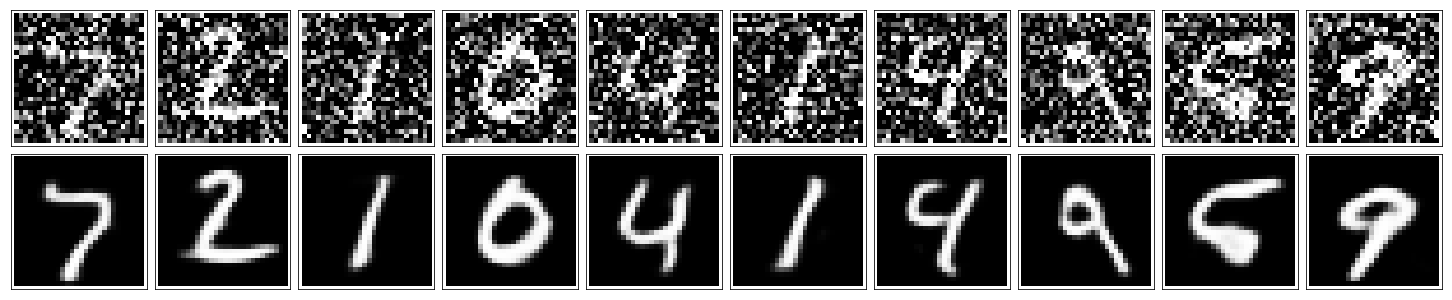

In [15]:
noise_factor = 0.5
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)